All of this can be found [here](https://www.vtk.org/Wiki/VTK/Examples/Python/vtkWithNumpy)

But also debugging stuff can be found here:
- [setDataExtent](https://gist.github.com/somada141/b125fd74916018ffe028)
- This is the [Jupyter notebook](http://nbviewer.jupyter.org/urls/bitbucket.org/somada141/pyscience/raw/master/20140908_SurfaceExtraction/Material/SurfaceExtractionVTK.ipynb) that was very useful in generating VTK images in Jupyter.

# Imports

In [1]:
# An example from scipy cookbook demonstrating the use of numpy arrys in vtk  
import vtk
import numpy as np
from IPython.display import Image

# Functions

In [2]:
def numpyToVTK(data_matrix):
    # For VTK to be able to use the data, it must be stored as a VTK-image. This can be done by the vtkImageImport-class which
    # imports raw data and stores it.
    dataImporter = vtk.vtkImageImport()
    # The preaviusly created array is converted to a string of chars and imported.
    data_string = data_matrix.tostring()
    dataImporter.CopyImportVoidPointer(data_string, len(data_string))
    # The type of the newly imported data is set to unsigned char (uint8)
    dataImporter.SetDataScalarTypeToUnsignedChar()
    # Because the data that is imported only contains an intensity value (it isnt RGB-coded or someting similar), the importer
    # must be told this is the case.
    dataImporter.SetNumberOfScalarComponents(1)
    
    # The following two functions describe how the data is stored and the dimensions of the array it is stored in. 
    extent = dataImporter.GetDataExtent()
    dim = stack.shape
    dataImporter.SetDataExtent(extent[0], extent[0] + dim[2] - 1,
                               extent[2], extent[2] + dim[1] - 1,
                               extent[4], extent[4] + dim[0] - 1)
    dataImporter.SetWholeExtent(extent[0], extent[0] + dim[2] - 1,
                                extent[2], extent[2] + dim[1] - 1,
                                extent[4], extent[4] + dim[0] - 1)
    
    return dataImporter    

In [3]:
def vtk_show(renderer, width=400, height=400):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = str(buffer(writer.GetResult()))
    
    return Image(data)

# Main

## Reading the Data

In [4]:
dbDir = 'C:/Cerebral/_MarioSandBox/DB/medicalHolography/pythonVariables/'
filteredImageFileName = dbDir + 'thStackMorphologyApplied.npy'

In [5]:
stack = np.load(filteredImageFileName)

In [6]:
np.shape(stack)

(180L, 760L, 766L)

In [7]:
stack.dtype

dtype('uint8')

In [8]:
data_matrix = stack

In [9]:
np.amax(data_matrix[0])

255

In [10]:
np.amin(data_matrix[0])

0

## VTK Stuff 

In [11]:
dataImporter = numpyToVTK(stack)

In [12]:
# The following class is used to store transparencyv-values for later retrival. In our case, we want the value 0 to be
# completly opaque whereas the three different cubes are given different transperancy-values to show how it works.
alphaChannelFunc = vtk.vtkPiecewiseFunction()
alphaChannelFunc.AddPoint(0, 0.0)
#alphaChannelFunc.AddPoint(50, 0.05)
#alphaChannelFunc.AddPoint(100, 0.1)
#alphaChannelFunc.AddPoint(150, 0.2)
alphaChannelFunc.AddPoint(255, 0.2)
 
# This class stores color data and can create color tables from a few color points. For this demo, we want the three cubes
# to be of the colors red green and blue.
colorFunc = vtk.vtkColorTransferFunction()
colorFunc.AddRGBPoint(0, 1.0, 0.0, 0.0)
#colorFunc.AddRGBPoint(50, 1.0, 0.0, 0.0)
#colorFunc.AddRGBPoint(100, 0.0, 1.0, 0.0)
#colorFunc.AddRGBPoint(150, 0.0, 0.0, 1.0)
colorFunc.AddRGBPoint(255, 0.0, 0.0, 1.0)

# The preavius two classes stored properties. Because we want to apply these properties to the volume we want to render,
# we have to store them in a class that stores volume prpoperties.
volumeProperty = vtk.vtkVolumeProperty()
volumeProperty.SetColor(colorFunc)
volumeProperty.SetScalarOpacity(alphaChannelFunc)

In [13]:
# This class describes how the volume is rendered (through ray tracing).
compositeFunction = vtk.vtkVolumeRayCastCompositeFunction()
# We can finally create our volume. We also have to specify the data for it, as well as how the data will be rendered.
volumeMapper = vtk.vtkVolumeRayCastMapper()
volumeMapper.SetVolumeRayCastFunction(compositeFunction)
volumeMapper.SetInputConnection(dataImporter.GetOutputPort())
 
# The class vtkVolume is used to pair the preaviusly declared volume as well as the properties to be used when rendering that volume.
volume = vtk.vtkVolume()
volume.SetMapper(volumeMapper)
volume.SetProperty(volumeProperty)

In [89]:
volume.SetPosition(0.0,0.0,0.0)

In [105]:
# With almost everything else ready, its time to initialize the renderer and window, as well as creating a method for exiting the application
renderer = vtk.vtkRenderer()
renderWin = vtk.vtkRenderWindow()
renderWin.AddRenderer(renderer)
renderInteractor = vtk.vtkRenderWindowInteractor()
renderInteractor.SetRenderWindow(renderWin)
 
# We add the volume to the renderer ...
renderer.AddVolume(volume)
# ... set background color to white ...
renderer.SetBackground(0,0,0)
# ... and set window size.
renderWin.SetSize(400, 400)

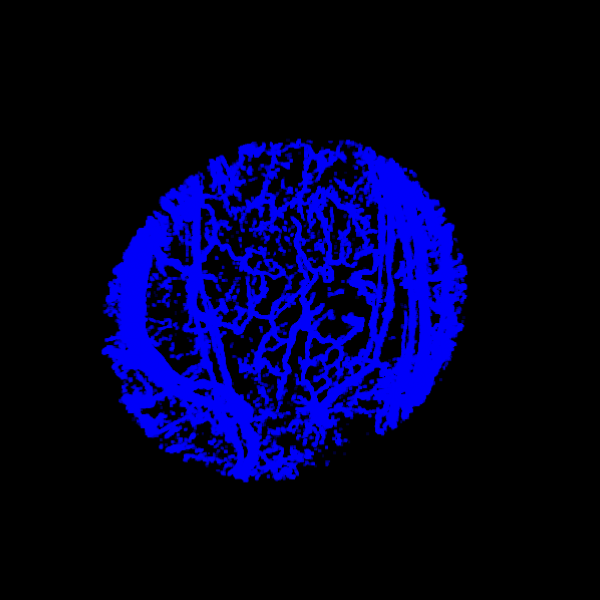

In [106]:
vtk_show(renderer, 600, 600)